# Data Engineering Project : Sentiment Analysis

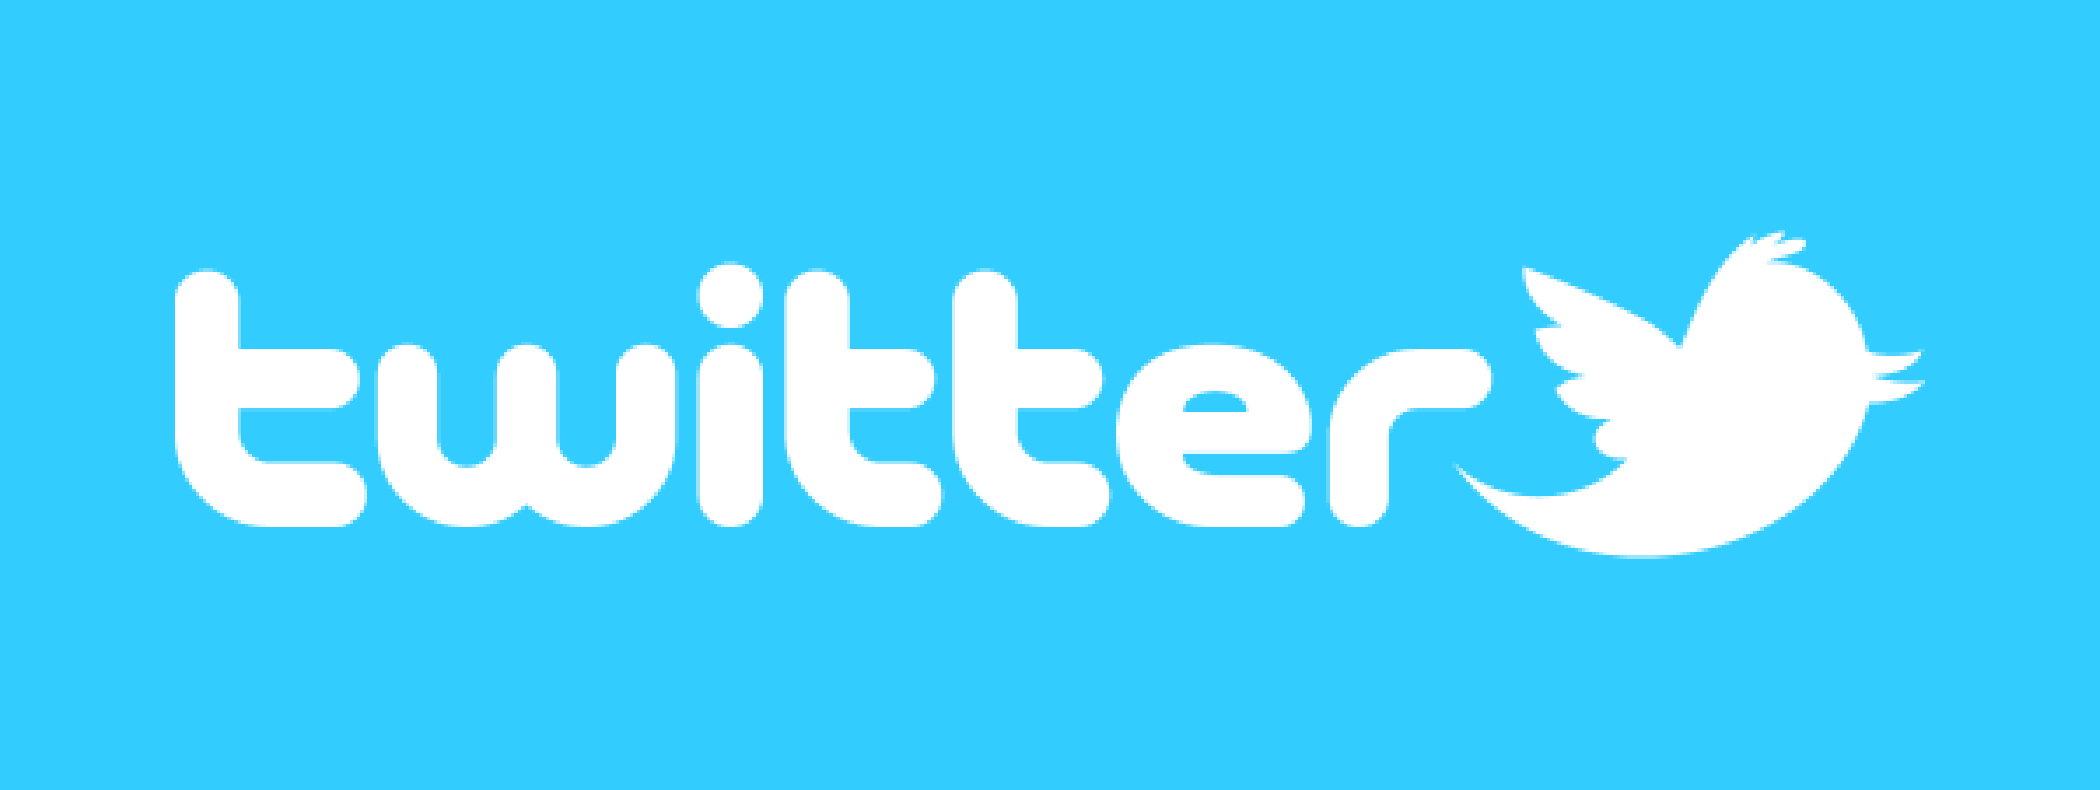

In [1]:
from IPython.display import Image
Image("logo.png")

## Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import re
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score,accuracy_score,roc_curve,auc
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore",category = FutureWarning)
warnings.filterwarnings("ignore",category= DeprecationWarning)


Bad key "text.kerning_factor" on line 4 in
C:\Users\ayeah\Documents\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
data = pd.read_csv("sentiment.tsv",sep = "\t")
data.columns = ['sentiment','text']
data.head()

,sentiment,text
0,neg,"@jamielewislewis i cant believe it, it really ..."
1,neg,Had a dream about a walk in fast food resturau...
2,neg,hates @internet @explrer (angry)(angry) **but ...
3,neg,@federalcase I said I go out for eat 5:negneg...
4,neg,@babykates7 yeah they won't do the surgery til...


In [4]:
print("Dataset size:", len(data))

Dataset size: 2001


In [5]:
#0 for negative sentiments
#1 for positive

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['sentiment'] = le.fit_transform(data['sentiment'])
data.head()

,sentiment,text
0,0,"@jamielewislewis i cant believe it, it really ..."
1,0,Had a dream about a walk in fast food resturau...
2,0,hates @internet @explrer (angry)(angry) **but ...
3,0,@federalcase I said I go out for eat 5:negneg...
4,0,@babykates7 yeah they won't do the surgery til...


In [7]:
def remove_pattern(input_txt,pattern):
    r = re.findall(pattern,input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

# Preprocessing

In [8]:
#Remove handles

data['cleanText'] = np.vectorize(remove_pattern)(data['text'],"@[\w]*")
#Remove special characters etc..
data['cleanText'] = data['cleanText'].str.replace("[^a-zA-Z#]"," ")

print(data.head())
print('******************************************************************')

#Tokenization
tokenized_tweet = data['cleanText'].apply(lambda x: x.split())

print(tokenized_tweet.head())
print('******************************************************************')
#stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 

print(tokenized_tweet.head())
print('******************************************************************')
#Merge tokenized word in the dataset
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
data['cleanText'] = tokenized_tweet

data.head()

   sentiment                                               text  \
0          0  @jamielewislewis i cant believe it, it really ...   
1          0  Had a dream about a walk in fast food resturau...   
2          0  hates @internet @explrer (angry)(angry) **but ...   
3          0  @federalcase  I said I go out for eat 5:negneg...   
4          0  @babykates7 yeah they won't do the surgery til...   

                                           cleanText  
0   i cant believe it  it really doesnt belong th...  
1  Had a dream about a walk in fast food resturau...  
2  hates    angry  angry    but no choice    http...  
3    I said I go out for eat   negneg p m   I dis...  
4   yeah they won t do the surgery till the cold ...  
******************************************************************
0    [i, cant, believe, it, it, really, doesnt, bel...
1    [Had, a, dream, about, a, walk, in, fast, food...
2    [hates, angry, angry, but, no, choice, http, p...
3    [I, said, I, go, out, for, eat

,sentiment,text,cleanText
0,0,"@jamielewislewis i cant believe it, it really ...",i cant believ it it realli doesnt belong there...
1,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...
2,0,hates @internet @explrer (angry)(angry) **but ...,hate angri angri but no choic http plurk com p...
3,0,@federalcase I said I go out for eat 5:negneg...,I said I go out for eat negneg p m I disappoin...
4,0,@babykates7 yeah they won't do the surgery til...,yeah they won t do the surgeri till the cold i...


In [9]:
#To have ponctuation rate
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")),3)*100

In [10]:
data['textlenght'] = data['text'].apply(lambda x:len(x) - x.count(" "))
data['punct_rate'] = data['text'].apply(lambda x:count_punct(x))
data.head()

,sentiment,text,cleanText,textlenght,punct_rate
0,0,"@jamielewislewis i cant believe it, it really ...",i cant believ it it realli doesnt belong there...,114,4.4
1,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...,96,1.0
2,0,hates @internet @explrer (angry)(angry) **but ...,hate angri angri but no choic http plurk com p...,75,21.3
3,0,@federalcase I said I go out for eat 5:negneg...,I said I go out for eat negneg p m I disappoin...,58,8.6
4,0,@babykates7 yeah they won't do the surgery til...,yeah they won t do the surgeri till the cold i...,82,6.1


# Feature Engeneering

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(stop_words='english')
bow = bow_vectorizer.fit_transform(data['cleanText'])
X_count_feat = pd.concat([data['textlenght'],data['punct_rate'],pd.DataFrame(bow.toarray())],axis = 1)
X_count_feat.head()

,textlenght,punct_rate,0,1,2,3,4,5,6,7,...,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944
0,114,4.4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,96,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,75,21.3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,58,8.6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,82,6.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Logistic Regression Algorithms

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
model=[]
model.append(('LR',LogisticRegression()))

In [13]:
for mod,clf in model:
    scores = cross_val_score(clf,X_count_feat,data['sentiment'],scoring = 'accuracy',cv = 10)
    print("The %s Model have a Score = %f"%(mod,scores.mean()))

The LR Model have a Score = 0.674613


In [14]:
param_grid = {'C':[0.001,0.01,0.1,1,10,100]}
grid = GridSearchCV(LogisticRegression(),param_grid,cv = 10)
grid.fit(X_count_feat,data['sentiment'])

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
grid.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
Logistic_model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
scores = cross_val_score(Logistic_model,X_count_feat,data['sentiment'],scoring='accuracy',cv=10)
print("The %s Model have a Score = %f"%("LR",scores.mean()))

The LR Model have a Score = 0.688581


# Final Prediction

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_count_feat, data['sentiment'], test_size=0.4, random_state=42)


In [18]:
model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
model.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
pred = model.predict(X_test)
pred

array([1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,

In [20]:
y_test

1394    1
353     0
1334    1
906     0
1290    1
       ..
461     0
1303    1
1177    1
377     0
798     0
Name: sentiment, Length: 801, dtype: int32

In [21]:
y_train

1103    1
105     0
126     0
1955    1
1131    1
       ..
1130    1
1294    1
860     0
1459    1
1126    1
Name: sentiment, Length: 1200, dtype: int32

In [22]:
accuracy_score(pred,y_test)

0.6816479400749064

In [23]:
confusion_matrix(y_test,pred)

array([[266, 132],
       [123, 280]], dtype=int64)